# Аналіз методів розпізнавання рукописних цифр

### Курсова студента 4 курсу Статистики Гайовича Богдана

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from copy import deepcopy

Using TensorFlow backend.


In [2]:
class config:
    IM_RES = (28, 28)
    RAW_IM_PATH = "Handwritten_numbers"
    NFOLDS = 10
    SCORES = []

In [3]:
class DataLoader():
    def __init__(self, path):
        self.folder = path
        self.raw_images = []
        self.samples = None
        self.labels = None
        
        self.Xtrain = None
        self.Xtest = None
        self.ytrain = None
        self.ytest = None
    
    
    def load_raw_ims(self):
        self.raw_images = []
        for f in os.listdir(self.folder):
            self.raw_images.append(cv2.imread(os.path.join(self.folder, f)))
            
        print("Loaded {} raw images from disk".format(len(self.raw_images)))
        
    
    def process_raw_ims(self):
        width = self.raw_images[0].shape[1] // 8
        height = self.raw_images[0].shape[0] // 18
        self.samples = []
        self.labels = []
        for i, im in enumerate(self.raw_images):
            for vertical_step in range(18):
                for horizontal_step in range(8):
#                     cut raw image so we get the image of a number
                    im1 = im[vertical_step*height:(vertical_step+1) * height, 
                             horizontal_step*width : (horizontal_step + 1)*width].copy()
                    im1_neg = 255 - im1.mean(axis=2)
                    im1_neg[im1_neg <= 10] = 0
                    x = np.argmax(im1_neg, axis=0)
                    y = np.argmax(im1_neg, axis=1)

#                     find coordinates of the smallest square that contains the number
#                     add small frame around the number
                    top = np.nonzero(y)[0][0] - 10
                    bot = np.nonzero(y)[0][-1] + 10
                    h = bot - top
                    left = np.nonzero(x)[0][0] - 10
                    right = np.nonzero(x)[0][-1] + 10
                    w = right - left

#                     make image square
                    if h > w:
                        side = (h - w) // 2
                        left -= side
                        right += side
                    else:
                        side = (h - w) // 2
                        top -= side
                        bot += side

#                     cut image by the coordinates and resize it ti standart size
                    im_cutted = im1_neg[top:bot, left:right].copy()
                    im_cutted = cv2.resize(im_cutted, config.IM_RES)

                    label = (i * 2 + 1 + vertical_step // 9) % 10
                    
                    
                    self.samples.append(im_cutted)
                    self.labels.append(label)
        
        self.samples = np.array(self.samples)
        self.samples = self.samples.reshape(self.samples.shape[0], 
                                            config.IM_RES[0], 
                                            config.IM_RES[1], 1)
        self.labels = np.array(self.labels)
        
        
        print("Successfully cut raw images into {} samples".format(self.samples.shape[0]))

                    
    def plot_numbers(self, num=8, images=None, labels=None):
        num_rows = max(1, num // 8)
        if num % 8 > 0:
            num_rows += 1
            
        fig, axs =  plt.subplots(num_rows, 8, figsize=(16, 2 * num_rows), sharey=True, squeeze=False)
        
        if images is not None and labels is not None:
            print("Plotting random {} images from the given set".format(num))
            rand_ind = np.random.randint(images.shape[0], size=num)
            images = images[rand_ind]
            labels = labels[rand_ind]
        else:
            rand_ind = np.random.randint(self.samples.shape[0], size=num)
            images = self.samples[rand_ind]
            labels = self.labels[rand_ind]
        
        for i in range(num):
            row = i // 8
            col = i % 8
            axs[row][col].imshow(images[i].reshape(config.IM_RES[0], 
                                                   config.IM_RES[1]), cmap='gray')
            axs[row][col].axis("off")
            axs[row][col].set_title("label = {}".format(labels[i]))
        
        plt.show()
    
    
    def data_augmentation(self, times=0.3, show=True):
        if show:
            print("Augmenting data by {} %".format(times * 100))
        aug_size = round(self.Xtrain.shape[0] * times)
        
        generator = ImageDataGenerator(
            rotation_range=10,
            zoom_range = 0.05, 
            width_shift_range = 0.05,
            height_shift_range = 0.05,
            horizontal_flip=False,
            vertical_flip=False, 
            data_format="channels_last")

        # get transformed images        
        rand_ind = np.random.randint(self.train_size, size=aug_size)
        samples_aug = self.Xtrain[rand_ind].copy()
        labels_aug = self.ytrain[rand_ind].copy()
        
        samples_aug = generator.flow(samples_aug, np.zeros(aug_size),
                                     batch_size=aug_size, shuffle=False).next()[0]
        # append augmented data to trainset
        self.Xtrain = np.concatenate((self.Xtrain, samples_aug))
        self.ytrain = np.concatenate((self.ytrain, labels_aug))
        self.train_size = self.Xtrain.shape[0]

        if show:     
            print("Successfully augmented data... Created {} new train samples".format(samples_aug.shape[0]))
            self.plot_numbers(images=samples_aug, labels=labels_aug)
    
    
    def split_data(self, test_size, show=True):
        self.Xtrain, self.Xtest, self.ytrain, self.ytest = train_test_split(self.samples, 
                                                                            self.labels, 
                                                                            test_size=test_size)
        self.train_size = self.Xtrain.shape[0]
        self.test_size = self.Xtest.shape[0]
        
        if show:
            print("Created {} train samples\n\t{} test samples".format(self.train_size, self.test_size))
        

# Завантажуємо та оброляємо дані

In [4]:
data = DataLoader(config.RAW_IM_PATH)

Loaded 5 raw images from disk
Successfully cut raw images into 720 samples


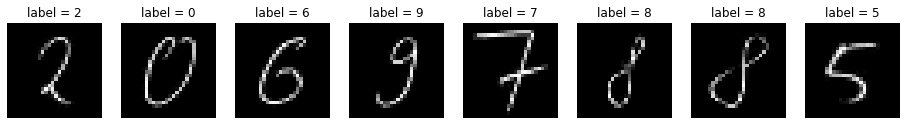

In [5]:
data.load_raw_ims()
data.process_raw_ims()
data.plot_numbers()

In [14]:
data.split_data(test_size=0.3)

Created 504 train samples
	216 test samples


Augmenting data by 200 %
Successfully augmented data... Created 1008 new train samples
Plotting random 8 images from the given set


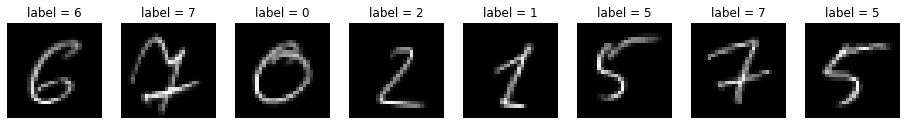

In [7]:
data.data_augmentation(times=2)

Plotting random 24 images from the given set


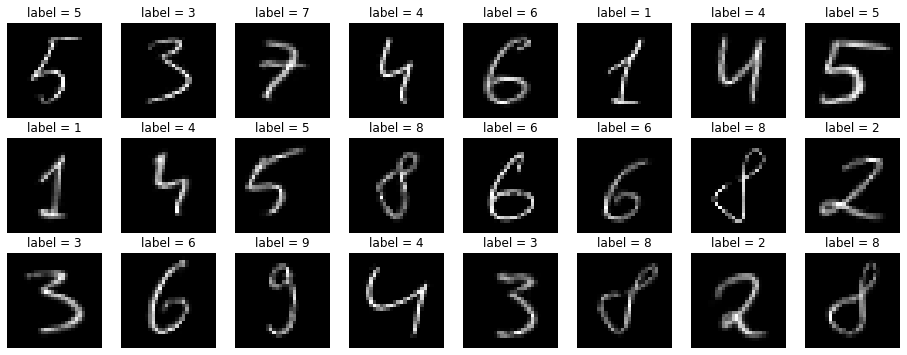

In [8]:
data.plot_numbers(num=24, images=data.Xtrain, labels=data.ytrain)

# ПОБУДОВА МОДЕЛЕЙ

# KNN (К-найближчих сусідів)

Спершу визначимо параметр К

In [24]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from scipy.stats import ttest_ind

In [21]:
scores = []
data.split_data(test_size=0.3)
for n in range(1, 31):
    model_knn = KNN(n_neighbors=n)
    model_knn.fit(data.Xtrain.reshape(data.train_size, config.IM_RES[0] ** 2), data.ytrain)
    scores.append([n, model_knn.score(data.Xtest.reshape(data.test_size, config.IM_RES[0] ** 2), 
                                 data.ytest)])

scores = np.array(scores)

Created 504 train samples
	216 test samples


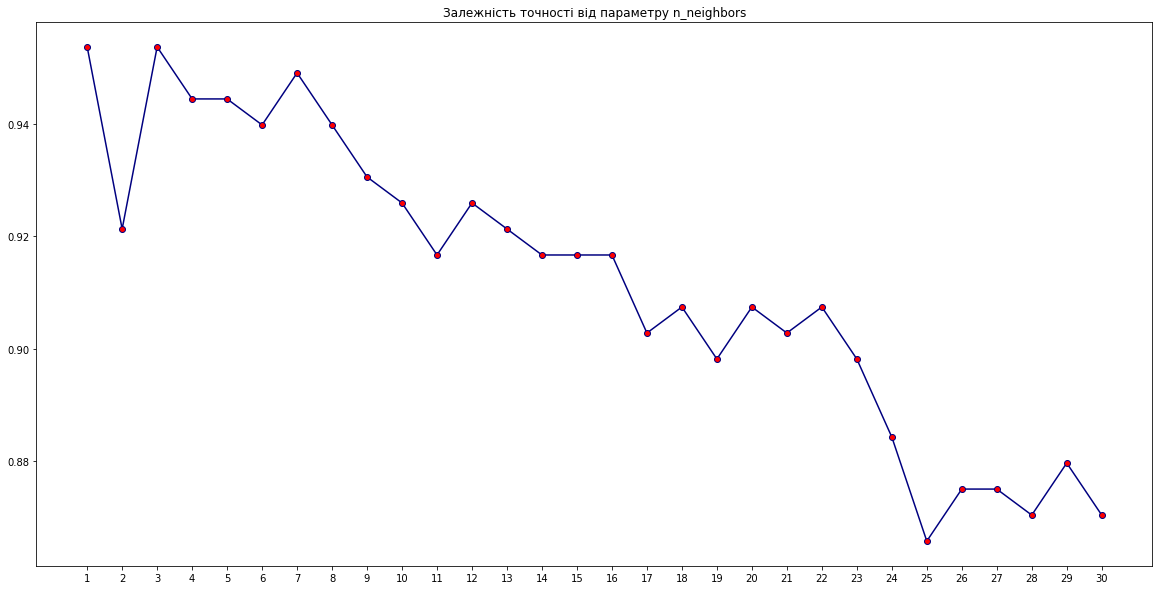

In [22]:
plt.figure(figsize=(20, 10))
plt.plot(scores[:, 0], scores[:, 1], color='navy', marker='o', markerfacecolor='red')
plt.xticks(ticks=scores[:, 0])
plt.title("Залежність точності від параметру n_neighbors")
plt.show()

Обираємо К = 3

Тепер робимо крос-валідацію з 10 фолдами для 2-х вибірок: зі збільшенням та без нього, щоб зрозуміти наскільки добре модель класифікує та чи впливає збілшення вибірки на результат

# KNN vs Logistic vs SVM vs Soft-voting vs Hard-voting

In [27]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC

In [28]:
def build_voting_classifier(type_voting = 'hard'):
    assert type_voting in ['hard', 'soft']
    
    VC = VotingClassifier(estimators=[('knn', KNN(n_neighbors=3)), 
                                      ('lr', LR(penalty='l2', tol=0.00001, 
                                                solver='newton-cg', max_iter=1000, 
                                                multi_class='auto')), 
                                      ('svm', SVC(gamma='scale', probability=True))], 
                          voting=type_voting)
    return VC

Із чистою вибіркою

In [31]:
model_knn = KNN(n_neighbors=3)
model_lr = LR(penalty='l2', tol=0.00001, solver='newton-cg', max_iter=1000, multi_class='auto') 
model_svm = SVC(gamma='scale')
ensemble_h = build_voting_classifier(type_voting='hard')
ensemble_s = build_voting_classifier(type_voting='soft')

all_scores_clean = []
for model, label in zip([model_knn, model_lr, model_svm, ensemble_h, ensemble_s], ['K-nearest', 'Logistic Regression', 'SVM Classifier', 'Ensemble (Hard)', 'Ensemble (Soft)']):
    scores = []
    for f in range(config.NFOLDS):
#     split the data
        data.split_data(test_size=0.3, show=False)

    #     train a model
        clf = deepcopy(model)
        clf.fit(data.Xtrain.reshape(data.train_size, config.IM_RES[0] ** 2), data.ytrain)
        scores.append(clf.score(data.Xtest.reshape(data.test_size, config.IM_RES[0] ** 2), data.ytest))
    scores = np.array(scores)
    print("Accuracy: %0.4f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    all_scores_clean.append([label, scores])

Accuracy: 0.9134 (+/- 0.01) [K-nearest]
Accuracy: 0.9611 (+/- 0.01) [Logistic Regression]
Accuracy: 0.9662 (+/- 0.01) [SVM Classifier]
Accuracy: 0.9556 (+/- 0.01) [Ensemble (Hard)]
Accuracy: 0.9639 (+/- 0.01) [Ensemble (Soft)]


In [32]:
ensemble_h = build_voting_classifier(type_voting='hard')
ensemble_s = build_voting_classifier(type_voting='soft')

all_scores_aug = []
for model, label in zip([model_knn, model_lr, model_svm, ensemble_h, ensemble_s], 
                        ['K-nearest', 'Logistic Regression', 'SVM Classifier', 'Ensemble (Hard)', 'Ensemble (Soft)']):
    scores = []
    for f in range(config.NFOLDS):
        
#     split the data
        data.split_data(test_size=0.3, show=False)

    #     enlarge train set by 200%
        data.data_augmentation(2, False)

    #     train a model
        clf = deepcopy(model)
        clf.fit(data.Xtrain.reshape(data.train_size, config.IM_RES[0] ** 2), data.ytrain)
        scores.append(clf.score(data.Xtest.reshape(data.test_size, config.IM_RES[0] ** 2), data.ytest))
        
    scores = np.array(scores)
    print("Accuracy: %0.4f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    all_scores_aug.append([label, scores])

Accuracy: 0.9537 (+/- 0.01) [K-nearest]
Accuracy: 0.9694 (+/- 0.01) [Logistic Regression]
Accuracy: 0.9852 (+/- 0.01) [SVM Classifier]
Accuracy: 0.9722 (+/- 0.01) [Ensemble (Hard)]
Accuracy: 0.9796 (+/- 0.01) [Ensemble (Soft)]


# Порівняємо результати з та без доповнення даних

За допомогою тесту Ст'юдента

In [33]:
for i in range(len(all_scores_aug)):
    l = all_scores_aug[i][0]
    s_aug = all_scores_aug[i][1]
    s_clean = all_scores_clean[i][1]
    
    p_value = ttest_ind(a=s_clean, b=s_aug, equal_var=False).pvalue
    
    print("P-value: %.4f [%s]" % (p_value, l), end='\t')
    if p_value >= 0.05:
        print("Mean accuracies are equal")
    else:
        print("Mean accuracies are not equal")

P-value: 0.0000 [K-nearest]	Mean accuracies are not equal
P-value: 0.0777 [Logistic Regression]	Mean accuracies are equal
P-value: 0.0008 [SVM Classifier]	Mean accuracies are not equal
P-value: 0.0079 [Ensemble (Hard)]	Mean accuracies are not equal
P-value: 0.0032 [Ensemble (Soft)]	Mean accuracies are not equal


Подивимося чи змінилася точність з та без використання ансамблю порівняно до SVM (який давав найбільші показники)

Для чистих даних

In [34]:
max_row = all_scores_clean[2]
for i in range(2, 0, -1):
    l = all_scores_clean[-i][0]
    s = all_scores_clean[-i][1]
    
    p_value = ttest_ind(a=s, b=max_row[1], equal_var=False).pvalue
    
    print("P-value: %.4f [%s]" % (p_value, l), end='\t')
    if p_value >= 0.05:
        print("Mean accuracies are equal")
    else:
        print("Mean accuracies are not equal")

P-value: 0.0762 [Ensemble (Hard)]	Mean accuracies are equal
P-value: 0.6533 [Ensemble (Soft)]	Mean accuracies are equal


Для розширених даних

In [35]:
max_row = all_scores_aug[2]
for i in range(2, 0, -1):
    l = all_scores_aug[-i][0]
    s = all_scores_aug[-i][1]
    
    p_value = ttest_ind(a=s, b=max_row[1], equal_var=False).pvalue
    
    print("P-value: %.4f [%s]" % (p_value, l), end='\t')
    if p_value >= 0.05:
        print("Mean accuracies are equal")
    else:
        print("Mean accuracies are not equal")

P-value: 0.0094 [Ensemble (Hard)]	Mean accuracies are not equal
P-value: 0.1752 [Ensemble (Soft)]	Mean accuracies are equal


Зобразимо всі отримані точності

In [36]:
import seaborn as sns
import pandas as pd

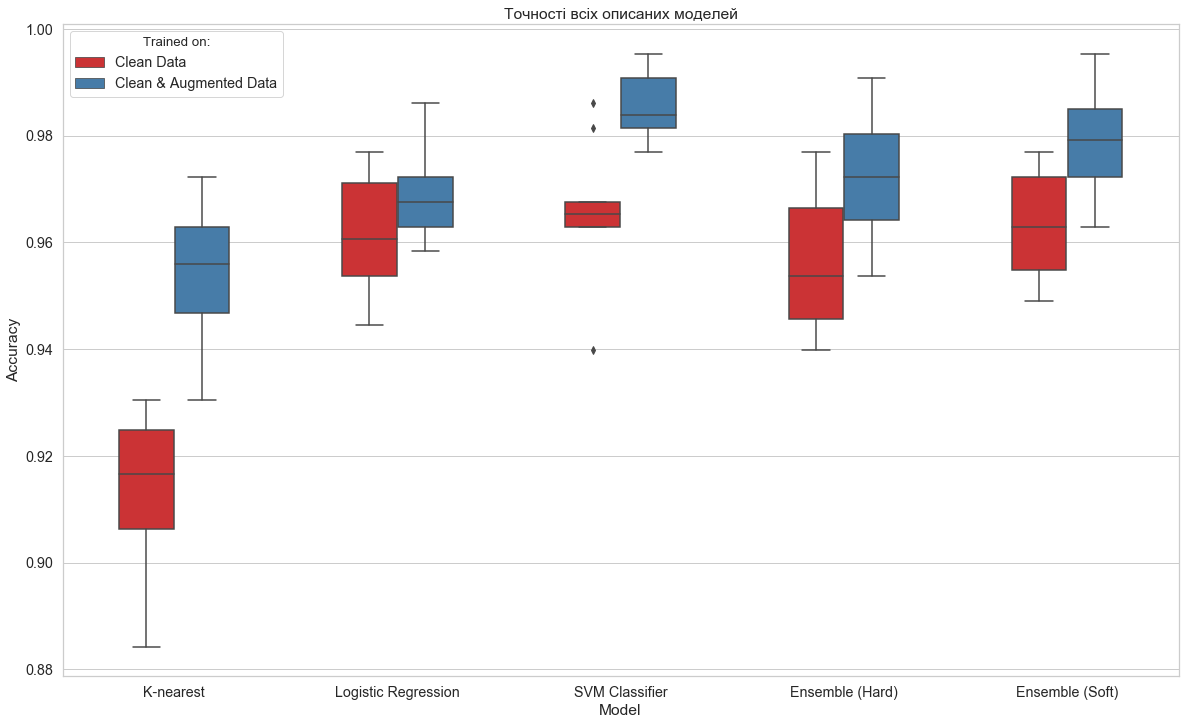

In [50]:
data_to_plot = []
for row in range(5):
    data_temp = all_scores_clean[row][1]
    l = all_scores_clean[row][0]
    for d in data_temp:
        data_to_plot.append([l, d, 'Clean Data'])
        
    data_temp = all_scores_aug[row][1]
    l = all_scores_aug[row][0]
    for d in data_temp:
        data_to_plot.append([l, d, 'Clean & Augmented Data'])
    
data_to_plot = pd.DataFrame(data_to_plot, columns=['Model', 'Accuracy', 'Trained on:'])

plt.figure(figsize=(20, 12))
sns.set(style="whitegrid", font_scale=1.3)
plt.title("Точності всіх описаних моделей")

ax = sns.boxplot(x="Model", y="Accuracy", hue="Trained on:", data=data_to_plot, palette="Set1", width=0.5)